In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from astropy.constants import G
import astropy.units as u
import warnings
import traceback
from colossus.cosmology import cosmology
import symlib
import csv

In [ ]:
def save_accretion_rates(base_dir, suite_name, output):

    # Create output directory
    output_dir = os.path.join(output, "output", suite_name)
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, f"accretion_rates.csv")

    # Open file for writing
    with open(output_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["halo_index", "gamma"])  # header

        i = 0
        while True:
            try:
                sim_dir = symlib.get_host_directory(base_dir, suite_name, i)
            except:
                break  # reached end of halo list

            try:
                scale = symlib.scale_factors(sim_dir)
                r, _ = symlib.read_rockstar(sim_dir)
                snap = len(scale) - 1
                m_now = r[0, snap]["m"]

                sim_params = symlib.simulation_parameters(sim_dir)
                cosmo = cosmology.setCosmology("custom", {
                    "flat": sim_params["flat"],
                    "H0": sim_params["H0"],
                    "Om0": sim_params["Om0"],
                    "Ob0": sim_params["Ob0"],
                    "sigma8": sim_params["sigma8"],
                    "ns": sim_params["ns"]
                })

                rho_m0 = cosmo.rho_m(0)
                Delta = 99
                rho_vir = Delta * rho_m0 * 1e9 / sim_params["h100"]**2
                G_val = G.to(u.Mpc**3 / (u.Msun * u.Gyr**2)).value
                t_dyn = 1.0 / np.sqrt((4 / 3) * np.pi * G_val * rho_vir)

                times = cosmo.age(1 / scale - 1)
                t0 = times[snap]
                t_past = t0 - t_dyn
                snap_past = np.argmin(np.abs(times - t_past))
                m_past = r[0, snap_past]["m"]

                gamma = (m_now - m_past) / t_dyn
                writer.writerow([i, gamma])

            except Exception as e:
                traceback.print_exc()
                warnings.warn(f"[{suite_name} - halo {i}] Error calculating accretion rate: {e}")
                writer.writerow([i, "nan"])  # still record halo_index

            i += 1

    print(f"[Saved] {suite_name} accretion rates → {output_path}")

save_accretion_rates('/Volumes/Atlas/Symphony', 'SymphonyLMC', "/Users/fengbocheng/Projects/Symphony-PPSD")
save_accretion_rates('/Volumes/Atlas/Symphony', 'SymphonyMilkyWay', "/Users/fengbocheng/Projects/Symphony-PPSD")
save_accretion_rates('/Volumes/Expansion/Symphony', 'SymphonyGroup', "/Users/fengbocheng/Projects/Symphony-PPSD")
save_accretion_rates('/Volumes/Atlas/Symphony', 'SymphonyLCluster', "/Users/fengbocheng/Projects/Symphony-PPSD")

In [6]:
def plot_ppsd_profiles_colored_by_accretion(base_dir, suite_name):

    # Directories
    profile_dir = os.path.join(base_dir, "output", suite_name, "ppsd_profiles")
    output_dir = os.path.join(base_dir, "output", suite_name, "figures")
    gamma_file = os.path.join(base_dir, "output", suite_name, "accretion_rates.csv")
    os.makedirs(output_dir, exist_ok=True)

    # Load accretion rate table
    df_gamma = pd.read_csv(gamma_file)
    gamma_dict = dict(zip(df_gamma["halo_index"], df_gamma["gamma"]))

    # Load profile data
    files = sorted([f for f in os.listdir(profile_dir) if f.endswith(".csv")])
    ppsd_r, ppsd_tot, mass_profiles, accretion_rates = [], [], [], []

    for f in files:
        df = pd.read_csv(os.path.join(profile_dir, f))
        r = df["r_scaled"].values
        Q_r = df["Q_r"].values
        Q_tot = df["Q_tot"].values
        m = df["m_scaled"].values
        ppsd_r.append(Q_r)
        ppsd_tot.append(Q_tot)
        mass_profiles.append(m)

        halo_id = int(f.split("_")[-1].split(".")[0])
        gamma = gamma_dict.get(halo_id, np.nan)
        accretion_rates.append(gamma)

    ppsd_r = np.array(ppsd_r)
    ppsd_tot = np.array(ppsd_tot)
    mass_profiles = np.array(mass_profiles)
    accretion_rates = np.array(accretion_rates)
    n_halos = len(ppsd_r)
    r_global = r  # All halo profiles assumed to share the same radial bins

    # Reference curves
    mean_Qr = np.nanmean(ppsd_r, axis=0)
    mean_Qtot = np.nanmean(ppsd_tot, axis=0)
    log_r = np.log(r_global)
    A_r = np.exp(np.mean(np.log(mean_Qr) + 1.875 * log_r))
    A_tot = np.exp(np.mean(np.log(mean_Qtot) + 1.875 * log_r))
    ref_curve_r = A_r * r_global**(-1.875)
    ref_curve_tot = A_tot * r_global**(-1.875)

    # Residuals
    residuals_r, residuals_tot = [], []
    for i in range(n_halos):
        res_r = np.log10(ppsd_r[i]) - np.log10(ref_curve_r)
        res_t = np.log10(ppsd_tot[i]) - np.log10(ref_curve_tot)
        residuals_r.append(res_r)
        residuals_tot.append(res_t)
    residuals_r = np.array(residuals_r)
    residuals_tot = np.array(residuals_tot)
    mean_res_r = np.nanmean(residuals_r, axis=0)
    std_res_r = np.nanstd(residuals_r, axis=0)
    mean_res_tot = np.nanmean(residuals_tot, axis=0)
    std_res_tot = np.nanstd(residuals_tot, axis=0)

    # Colormap for accretion rate
    cmap = cm.plasma
    valid = ~np.isnan(accretion_rates)
    log_gamma = np.log10(np.where(valid, accretion_rates, 1))
    norm = plt.Normalize(vmin=np.nanmin(log_gamma[valid]), vmax=np.nanmax(log_gamma[valid]))
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    # --- Figure 1: Q vs r ---
    fig1, ax1 = plt.subplots(1, 2, figsize=(14, 5), dpi=500, constrained_layout=True)
    for i in range(n_halos):
        color = 'gray' if np.isnan(log_gamma[i]) else cmap(norm(log_gamma[i]))
        ax1[0].plot(r_global, ppsd_r[i], color=color, lw=0.7)
        ax1[1].plot(r_global, ppsd_tot[i], color=color, lw=0.7)
    ax1[0].set(title=r"$Q_r$ vs $r$", xscale="log", yscale="log", xlabel=r"$r / r_{\rm vir}$", ylabel=r"$Q_r$")
    ax1[1].set(title=r"$Q_{\rm tot}$ vs $r$", xscale="log", yscale="log", xlabel=r"$r / r_{\rm vir}$", ylabel=r"$Q_{\rm tot}$")
    for ax in ax1: ax.grid(True, which="both", linestyle=":")
    fig1.colorbar(sm, ax=ax1.ravel().tolist(), shrink=0.9).set_label(r"$\log_{10}(\Gamma)$ [M$_\odot$/Gyr]")
    fig1.suptitle(f"PPSD vs r (Colored by Accretion Rate): {suite_name}")
    fig1.savefig(os.path.join(output_dir, "PPSD_vs_r (colored by accretion).png"))
    plt.show()
    plt.close(fig1)

    # --- Figure 2: Q vs M(<r) ---
    fig2, ax2 = plt.subplots(1, 2, figsize=(14, 5), dpi=500, constrained_layout=True)
    for i in range(n_halos):
        color = 'gray' if np.isnan(log_gamma[i]) else cmap(norm(log_gamma[i]))
        ax2[0].plot(mass_profiles[i], ppsd_r[i], color=color, lw=0.7)
        ax2[1].plot(mass_profiles[i], ppsd_tot[i], color=color, lw=0.7)
    ax2[0].set(title=r"$Q_r$ vs $M(<r)$", xscale="log", yscale="log", xlabel=r"$M(<r)/M_{\rm vir}$", ylabel=r"$Q_r$")
    ax2[1].set(title=r"$Q_{\rm tot}$ vs $M(<r)$", xscale="log", yscale="log", xlabel=r"$M(<r)/M_{\rm vir}$", ylabel=r"$Q_{\rm tot}$")
    for ax in ax2: ax.grid(True, which="both", linestyle=":")
    fig2.colorbar(sm, ax=ax2.ravel().tolist(), shrink=0.9).set_label(r"$\log_{10}(\Gamma)$ [M$_\odot$/Gyr]")
    fig2.suptitle(f"PPSD vs Mass (Colored by Accretion Rate): {suite_name}")
    fig2.savefig(os.path.join(output_dir, "PPSD_vs_mass (colored by accretion).png"))
    plt.show()
    plt.close(fig2)

    # --- Figure 3: Residuals ---
    fig3, ax3 = plt.subplots(1, 2, figsize=(14, 5), dpi=500, constrained_layout=True)
    for i in range(n_halos):
        color = 'gray' if np.isnan(log_gamma[i]) else cmap(norm(log_gamma[i]))
        ax3[0].plot(r_global, residuals_r[i], color=color, lw=0.7)
        ax3[1].plot(r_global, residuals_tot[i], color=color, lw=0.7)
    ax3[0].plot(r_global, mean_res_r, 'k-', lw=1)
    ax3[0].fill_between(r_global, mean_res_r - std_res_r, mean_res_r + std_res_r, color='gray', alpha=0.3)
    ax3[0].axhline(0, color='r', linestyle='--', lw=1)
    ax3[0].set(title=r"$\log_{10}(Q_r/Q_{\rm ref})$ vs $r / r_{\rm vir}$", xlabel=r"$r / r_{\rm vir}$", ylabel=r"$\log_{10}(Q_r/Q_{\rm ref})$", xscale="log", ylim=(-1.5, 1.5))
    ax3[1].plot(r_global, mean_res_tot, 'k-', lw=1)
    ax3[1].fill_between(r_global, mean_res_tot - std_res_tot, mean_res_tot + std_res_tot, color='gray', alpha=0.3)
    ax3[1].axhline(0, color='r', linestyle='--', lw=1)
    ax3[1].set(title=r"$\log_{10}(Q_{\rm tot}/Q_{\rm ref})$ vs $r / r_{\rm vir}$", xlabel=r"$r / r_{\rm vir}$", ylabel=r"$\log_{10}(Q_{\rm tot}/Q_{\rm ref})$", xscale="log", ylim=(-1.5, 1.5))
    for ax in ax3: ax.grid(True, which="both", linestyle=":")
    fig3.colorbar(sm, ax=ax3.ravel().tolist(), shrink=0.9).set_label(r"$\log_{10}(\Gamma)$ [M$_\odot$/Gyr]")
    fig3.suptitle(f"PPSD Residuals (Colored by Accretion Rate): {suite_name}")
    fig3.savefig(os.path.join(output_dir, "PPSD_residuals (colored by accretion).png"))
    plt.show()
    plt.close(fig3)

    print(f"[Saved] Accretion-rate-colored PPSD figures for {suite_name}")

In [ ]:
base_dir = "/Users/fengbocheng/Projects/Symphony-PPSD"
suite_names = [
    "SymphonyLMC",
    "SymphonyMilkyWay",
    "SymphonyGroup",
    "SymphonyLCluster",
    "SymphonyCluster",
]

for suite in suite_names:
    plot_ppsd_profiles_colored_by_accretion(base_dir, suite)

In [ ]:
def plot_ppsd_slope_colored_by_accretion(base_dir, suite_name):
    # --- Directory setup ---
    slope_r_dir = os.path.join(base_dir, "output", suite_name, "ppsd_slope_profiles_r")
    slope_m_dir = os.path.join(base_dir, "output", suite_name, "ppsd_slope_profiles_m")
    accretion_path = os.path.join(base_dir, "output", suite_name, "accretion_rates.csv")
    output_dir = os.path.join(base_dir, "output", suite_name, "figures")
    os.makedirs(output_dir, exist_ok=True)

    # --- Load accretion rates ---
    if not os.path.exists(accretion_path):
        print(f"[Error] Accretion rate file not found: {accretion_path}")
        return
    df_gamma = pd.read_csv(accretion_path)
    gamma_dict = dict(zip(df_gamma["halo_index"], df_gamma["gamma"]))

    n_halos = len([f for f in os.listdir(slope_r_dir) if f.endswith(".csv")])
    accretion_rates = np.array([gamma_dict.get(i, np.nan) for i in range(n_halos)])
    log_gamma = np.log10(np.where((accretion_rates > 0) & np.isfinite(accretion_rates), accretion_rates, np.nan))

    # --- Color map setup ---
    cmap = cm.plasma
    norm = colors.Normalize(vmin=np.nanmin(log_gamma), vmax=np.nanmax(log_gamma))
    sm = cm.ScalarMappable(norm=norm, cmap=cmap)

    # --- Plot setup ---
    fig1, axes1 = plt.subplots(1, 2, figsize=(13, 5), dpi=500, constrained_layout=True)
    fig2, axes2 = plt.subplots(1, 2, figsize=(13, 5), dpi=500, constrained_layout=True)
    ax_slope_tot, ax_slope_rad = axes1
    ax_slope_tot_m, ax_slope_rad_m = axes2

    # Interpolated storage
    interp_r = np.logspace(-2.8, 0, 200)
    interp_m = np.logspace(-4, 0, 200)
    slopes_r_tot, slopes_r_rad = [], []
    slopes_m_tot, slopes_m_rad = [], []

    for i in range(n_halos):
        try:
            df_r = pd.read_csv(os.path.join(slope_r_dir, f"slope_profile_r_{i}.csv"))
            df_m = pd.read_csv(os.path.join(slope_m_dir, f"slope_profile_m_{i}.csv"))
        except Exception as e:
            print(f"[Halo {i}] CSV load failed: {e}")
            continue

        try:
            r = df_r["r_scaled"].values
            slope_Qr_r = df_r["slope_Q_r"].values
            slope_Qtot_r = df_r["slope_Q_tot"].values
            m = df_m["m_scaled"].values
            slope_Qr_m = df_m["slope_Q_r"].values
            slope_Qtot_m = df_m["slope_Q_tot"].values

            color = cmap(norm(log_gamma[i])) if np.isfinite(log_gamma[i]) else "gray"

            # Individual halo curves
            ax_slope_rad.plot(r, slope_Qr_r, color=color, lw=0.5, alpha=0.5)
            ax_slope_tot.plot(r, slope_Qtot_r, color=color, lw=0.5, alpha=0.5)
            ax_slope_rad_m.plot(m, slope_Qr_m, color=color, lw=0.5, alpha=0.5)
            ax_slope_tot_m.plot(m, slope_Qtot_m, color=color, lw=0.5, alpha=0.5)

            # Interpolate to common x-axis
            if np.all(np.isfinite(slope_Qtot_r)) and np.all(np.isfinite(slope_Qr_r)):
                slopes_r_tot.append(np.interp(interp_r, r, slope_Qtot_r, left=np.nan, right=np.nan))
                slopes_r_rad.append(np.interp(interp_r, r, slope_Qr_r, left=np.nan, right=np.nan))
            if np.all(np.isfinite(slope_Qtot_m)) and np.all(np.isfinite(slope_Qr_m)):
                slopes_m_tot.append(np.interp(interp_m, m, slope_Qtot_m, left=np.nan, right=np.nan))
                slopes_m_rad.append(np.interp(interp_m, m, slope_Qr_m, left=np.nan, right=np.nan))

        except Exception as e:
            print(f"[Halo {i}] Plotting failed: {e}")
            continue

    # --- Plot mean ±1σ shaded regions ---
    def plot_mean_std_interp(ax, x, y_interp_list, label="Mean", color="black"):
        y_array = np.array(y_interp_list)
        y_mean = np.nanmean(y_array, axis=0)
        y_std = np.nanstd(y_array, axis=0)
        ax.plot(x, y_mean, color=color, lw=1, label=label)
        ax.fill_between(x, y_mean - y_std, y_mean + y_std, color=color, alpha=0.2)

    plot_mean_std_interp(ax_slope_tot, interp_r, slopes_r_tot, r"Mean $d\log Q / d\log r$")
    plot_mean_std_interp(ax_slope_rad, interp_r, slopes_r_rad, r"Mean $d\log Q_r / d\log r$")
    plot_mean_std_interp(ax_slope_tot_m, interp_m, slopes_m_tot, r"Mean $d\log Q / d\log M$")
    plot_mean_std_interp(ax_slope_rad_m, interp_m, slopes_m_rad, r"Mean $d\log Q_r / d\log M$")

    # --- Axis formatting ---
    for ax, ylabel in zip([ax_slope_tot, ax_slope_rad],
                          [r"$\mathrm{d}\log Q / \mathrm{d}\log r$", r"$\mathrm{d}\log Q_r / \mathrm{d}\log r$"]):
        ax.set_xlabel(r"$r / R_\mathrm{vir}$")
        ax.set_ylabel(ylabel)
        ax.set_xscale("log")
        ax.set_ylim(-4, 1)
        ax.axhline(-1.875, color='k', ls='--', lw=0.7)
        ax.grid(True, which="both", linestyle=":")
        ax.legend()

    for ax, ylabel in zip([ax_slope_tot_m, ax_slope_rad_m],
                          [r"$\mathrm{d}\log Q / \mathrm{d}\log M$", r"$\mathrm{d}\log Q_r / \mathrm{d}\log M$"]):
        ax.set_xlabel(r"$M(<r) / M_\mathrm{vir}$")
        ax.set_ylabel(ylabel)
        ax.set_xscale("log")
        ax.set_ylim(-4, 1)
        ax.grid(True, which="both", linestyle=":")
        ax.legend()

    # --- Colorbar and save ---
    fig1.colorbar(sm, ax=axes1.ravel().tolist(), shrink=0.9).set_label(r"$\log_{10}(\Gamma)$ [M$_\odot$/Gyr]")
    fig2.colorbar(sm, ax=axes2.ravel().tolist(), shrink=0.9).set_label(r"$\log_{10}(\Gamma)$ [M$_\odot$/Gyr]")

    fig1.suptitle(f"{suite_name} PPSD Slopes vs Radius colored by Accretion Rate", y=1.05)
    fig2.suptitle(f"{suite_name} PPSD Slopes vs Mass colored by Accretion Rate", y=1.05)

    try:
        fig1.savefig(os.path.join(output_dir, "PPSD_slopes_r_colored_by_accretion.png"))
        fig2.savefig(os.path.join(output_dir, "PPSD_slopes_m_colored_by_accretion.png"))
        print("[Success] Saved interpolated slope plots colored by accretion rate")
        plt.show()
    except Exception as e:
        print(f"[Error] Failed to save figures: {e}")

    plt.close(fig1)
    plt.close(fig2)

/var/folders/ws/425czmvd4jn8yf9hxr3xtk880000gn/T/ipykernel_21775/720538335.py:76: RuntimeWarning: Mean of empty slice
  y_mean = np.nanmean(y_array, axis=0)
/Users/fengbocheng/PythonEnvs/Astronomy/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[Success] Saved interpolated slope plots colored by accretion rate


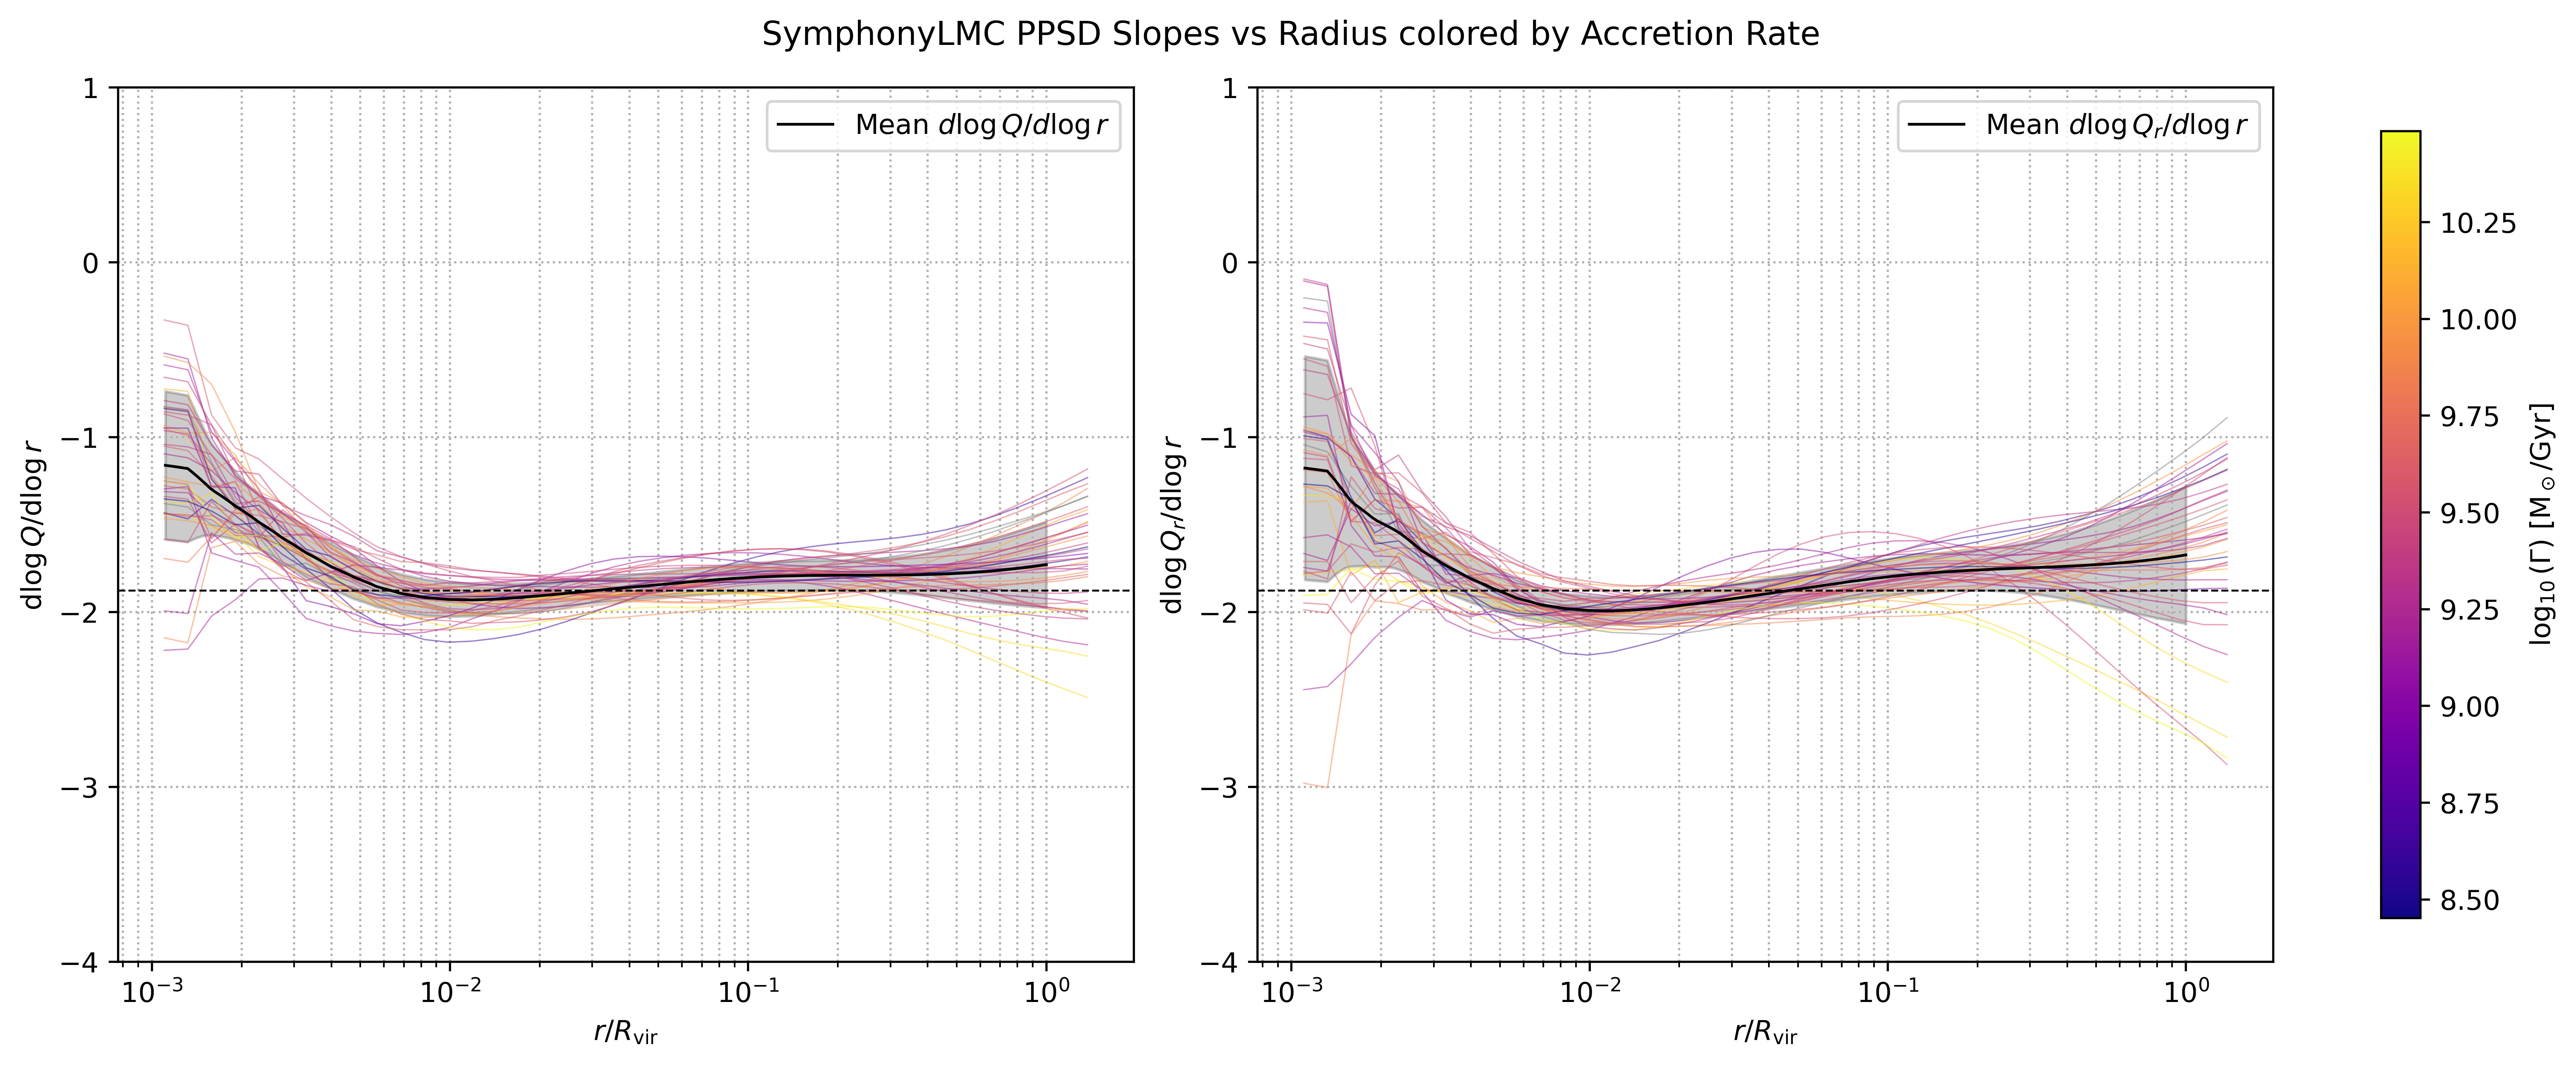

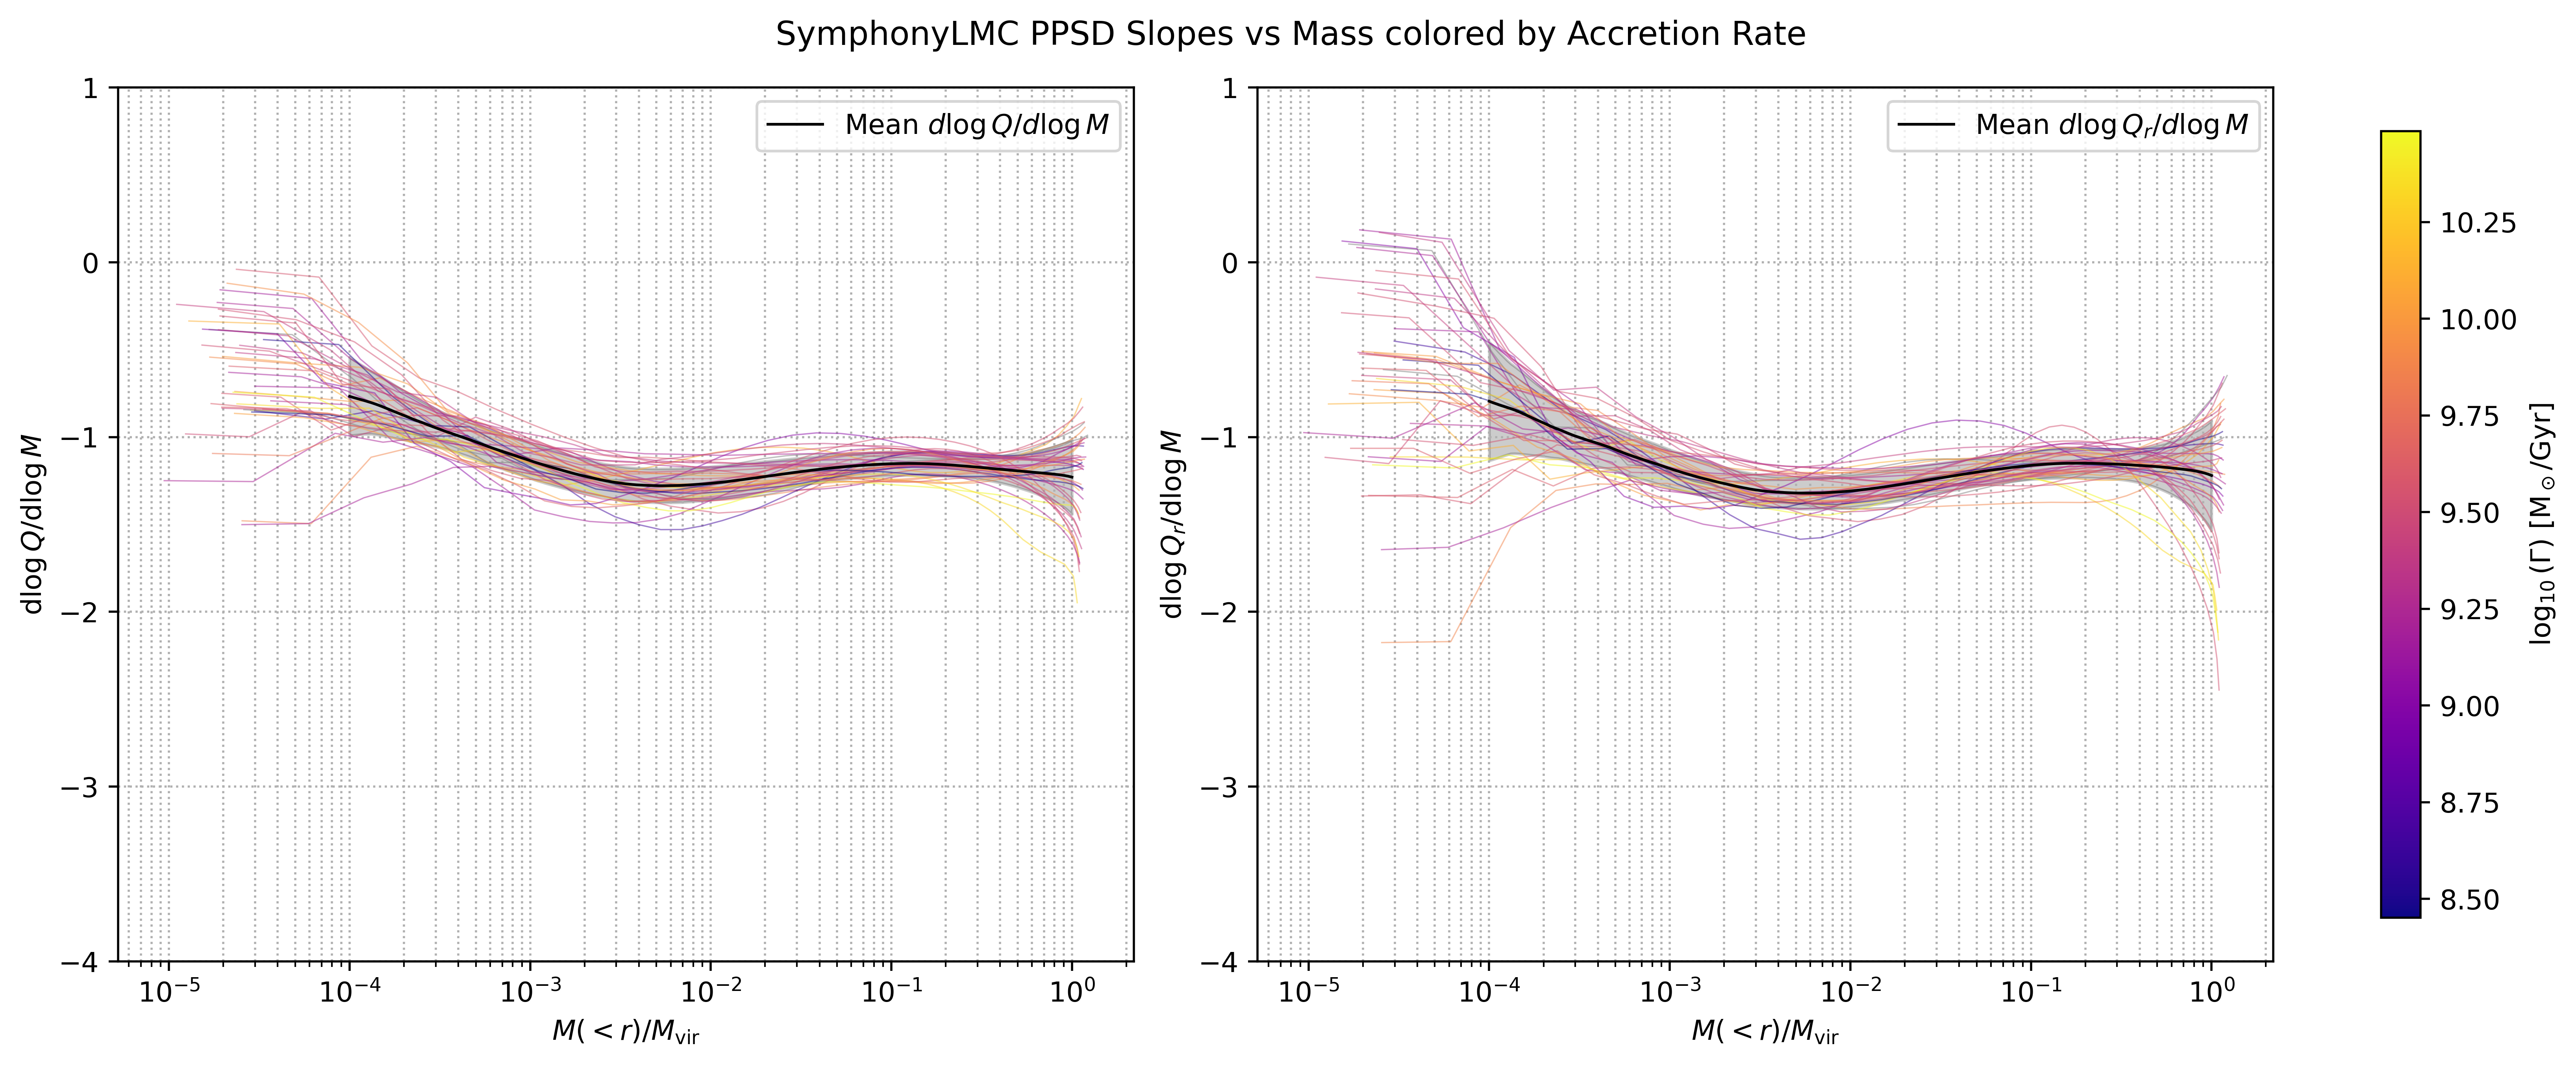

/var/folders/ws/425czmvd4jn8yf9hxr3xtk880000gn/T/ipykernel_21775/720538335.py:76: RuntimeWarning: Mean of empty slice
  y_mean = np.nanmean(y_array, axis=0)
/Users/fengbocheng/PythonEnvs/Astronomy/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[Success] Saved interpolated slope plots colored by accretion rate


KeyboardInterrupt: 

In [33]:
base_dir = "/Users/fengbocheng/Projects/Symphony-PPSD"
suite_names = [
    "SymphonyLMC",
    "SymphonyMilkyWay",
    "SymphonyGroup",
    "SymphonyLCluster",
    "SymphonyCluster",
]

for suite in suite_names:
    plot_ppsd_slope_colored_by_accretion(base_dir, suite)